In [1]:
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import LineString
from shapely.geometry import LinearRing
from shapely.geometry import CAP_STYLE, JOIN_STYLE


import itertools

import matplotlib.pyplot as plt
import numpy as np
import cv2

from numba import jit

%reload_ext autoreload
%autoreload 2

In [2]:
def point_dis(p1,p2):
    
    dx = p2.x-p1.x
    dy = p2.y-p1.y
    
    return np.sqrt(dx*dx+dy*dy)

In [3]:
def plot_ring(lr):
    
    X = []
    Y = []
    
    for p in list(lr.coords):
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y)

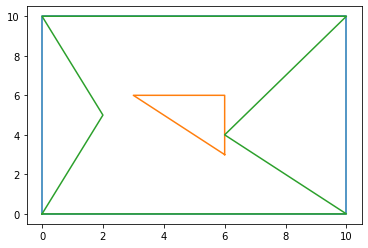

In [4]:
lr1 = LinearRing(
    [
        (0,0),
        (0, 10),
        (10,10),
        (10,0)
    ]
)

lr2 = LinearRing(
    [
        (6,3),
        (3,6),
        (6,6),
    ]
)

lr3 = LinearRing(
    [
        (0,0),
        (2,5),
        (0, 10),
        (10,10),
        (6,4),
        (10,0)
    ]
)

plot_ring(lr1)
plot_ring(lr2)
plot_ring(lr3)

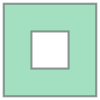

In [5]:
lr1 = Polygon(
    [
        (0,0),
        (0, 10),
        (10,10),
        (10,0)
    ], holes = [[(3,3),(3,7),(7,7),(7,3)]]
)
lr1

In [6]:
from shapely_utilities import distance_transform_diff

In [7]:
t = lr1.exterior.buffer(3, cap_style = CAP_STYLE.flat, join_style = JOIN_STYLE.mitre)

lr1.difference(t).is_empty

True

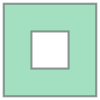

In [8]:
lr1

In [11]:
x = distance_transform_diff(lr1, 0.5)

A Polygon
B Polygon False
C Polygon False
A Polygon
B Polygon False
C Polygon False
A Polygon
B Polygon False
C Polygon False
A Polygon
B Polygon False
C Polygon False
A Polygon
B Polygon False
C Polygon False
A Polygon
B Polygon True
D 1
D 2
D 3
D 4
D 5


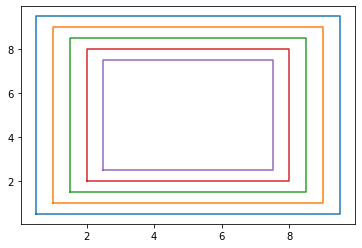

In [15]:
for poly in x:
    plot_ring(poly)

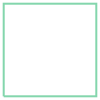

In [11]:
lr1.difference(lr1.exterior.buffer(2)).exterior

In [5]:
%load_ext autoreload
%autoreload 2

In [13]:
@jit(nopython=True)
def distance(p0,p1):
    return np.sqrt((p0[0]-p1[0])**2+(p0[1]-p1[1])**2)

@jit(nopython=True)
def distance_numba(ls):
    
    point = ls[0]
    
    for i in range(len(ls)):
        
        print(distance(point, ls[i]))
        
        
distance_numba(np.array(list(lr1.coords)))
    
    
    

0.0
10.0
14.142135623730951
10.0
0.0


878 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)
8.74 ms ± 43.3 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)


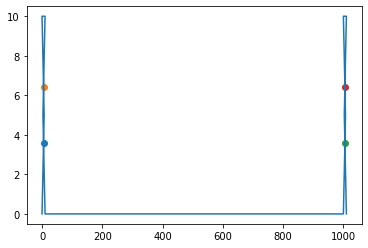

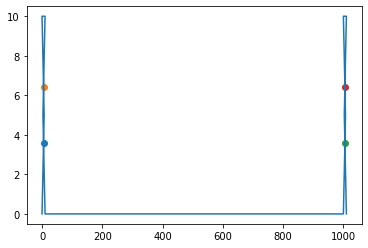

In [16]:
# create a nasty linestring (start and end intersections)
import shapely_utilities as SU

start = [
        (0,0),
        (7,5),
        (0, 10),
        (10,10),
        (3,5),
        (10,0)
    ]

middle = [(x,0) for x in range(11,1000)]

end = [
        (1000,0),
        (1007,5),
        (1000, 10),
        (1010,10),
        (1003,5),
        (1010,0)
    ]

ls = LineString(start+middle+end)




%timeit -n 3 SU.self_intersections(ls)

%timeit -n 3 SU.self_intersections_binary(ls)



i1 = SU.self_intersections(ls)
i2 = SU.self_intersections_binary(ls)


plot_ring(ls)
for i in i1:
    plt.scatter(i.x,i.y)
plt.show()
    
plot_ring(ls)
for i in i2:
    plt.scatter(i.x,i.y)
plt.show()

In [73]:
# evenly sample the linestring
def sample(ls, distance):
    
    pos = 0
    
    points = []
    
    while pos < ls.length:
        points.append(ls.interpolate(pos))
        
        pos += distance
        
    return points   
        
        
# get the curvature between 3 points
def curvature(p0,p1,p2):
    
    # side lengths
    A = p0.distance(p1)
    B = p0.distance(p2)
    C = p1.distance(p2)
    
    
    if A == 0 or B == 0 or C == 0:
        return 0
    
    
    # area of triange
    area = abs(0.5 * (p0.x*(p1.y-p2.y) + p1.x*(p2.y-p0.y) + p2.x*(p0.y-p1.y)))
    
    return (4*area)/(A*B*C)
    
# get the next vertex index in the linestring from a given point "p"
def get_next_index(ls, p):
    
    dis = ls.project(p)
    
    coords = [Point(p) for p in ls.coords]
    
    for i,p in enumerate(coords):
        if ls.project(p) > dis:
            return i
            
    return len(coords)-1

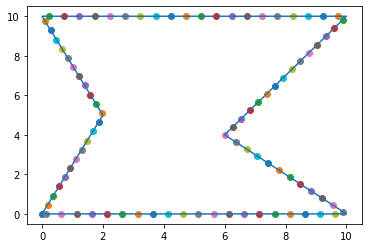

In [34]:
result = SU.sample(lr3, 0.5)

plot_ring(lr3)

for p in result.coords:
    plt.scatter(p[0],p[1])
    


# for p in [p0,p1,p2]:
#     plt.scatter(p.x,p.y)

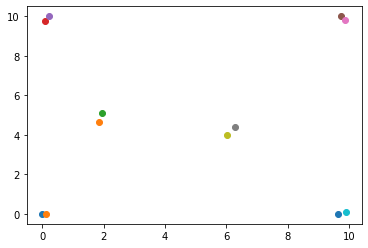

In [26]:
# test "adaptive sampling" using simplify

ls = LineString(result)

simplified = ls.simplify(0.01)

for p in simplified.coords:
    plt.scatter(p[0],p[1])

25.0
POINT (0 0) 0.1968366647947391
10.0
POINT (2 5) 0.13793103448275862
25.0
POINT (0 10) 0.19683666479473907
30.0
POINT (10 10) 0.19611613513818407
20.0
POINT (6 4) 0.19611613513818404
20.0
POINT (10 0) 0.19611613513818402


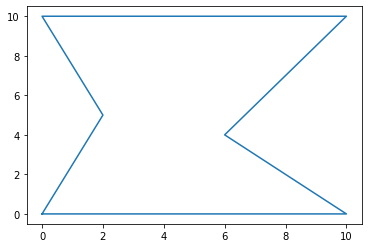

In [56]:

points = lr3.coords[:-1]

curvatures = []

for i in range(0, len(points)):
        
    p0 = Point(points[i-1])
    p1 = Point(points[i])
    p2 = Point(points[i+1 if i+1 < len(points) else 0])
    
    curvatures.append(curvature(p0,p1,p2))
    
    print(p1,curvatures[i])
        
plot_ring(lr3)

In [66]:

p0 = Point((1,0))
p1 = Point((0,0))
p2 = Point((1,1))
p3 = Point((1,0.000001))

curvature(p0,p1,p2)

1.414213562373095

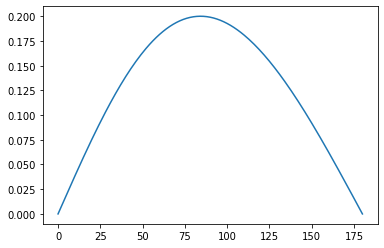

In [77]:
import math


curves = []

# move p3 around half a unit circle
for i in range(181):
     
    rad = math.radians(i)
    
    p3 = Point((np.cos(rad), np.sin(rad)))

    curves.append(curvature(p0,p1,p3))
    

plt.plot(curves)

In [70]:
p0 = Point((10,0))
p1 = Point((0,0))
p2 = Point((10,10))

curvature(p0,p1,p2)

0.1414213562373095

In [21]:
p0 = Point((0,0))
p1 = Point((1,1))
p0.angle(p1)

AttributeError: 'Point' object has no attribute 'angle'

LINESTRING (6 3, 3 6, 6 6, 6 3)


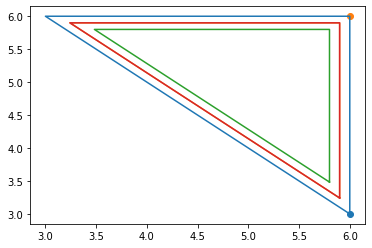

In [34]:
ls = LineString(list(lr2.coords)[0:])
print(ls)

plot_ring(lr2)
plot_ring(ls.buffer(0.1, join_style = 2, cap_style=2).interiors[0])
plot_ring(ls.buffer(0.2, join_style = 2, cap_style=2).interiors[0])

plt.scatter(lr2.coords[0][0],lr2.coords[0][1])
plt.scatter(lr2.coords[2][0],lr2.coords[2][1])

plot_ring(lr2.buffer(0.1).interiors[0])

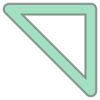

In [23]:
lr2.buffer(0.2)

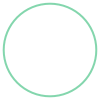

In [15]:
Point(0,0).buffer(1).exterior

In [5]:
x = LineString([(1,1),(4,5)])

In [22]:
def extend_linestring(line, dis=10):
    
    p1 = line.coords[0]
    p2 = line.coords[1]

    dx = p2[0]-p1[0]
    dy = p2[1]-p1[1]
    
    angle = np.arctan2(dy,dx)
    
    px = np.cos(angle)*dis + p2[0]
    py = np.sin(angle)*dis + p2[1]
    
    return LineString((line.coords[0], (px,py)))

POINT (7.75 10)


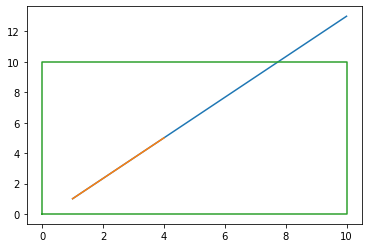

In [23]:
print(extend_linestring(x).intersection(lr1))

plot_ring(extend_linestring(x))
plot_ring(x)
pblot_ring(lr1)

In [29]:
print(Polygon(lr1).exterior)

LINEARRING (0 0, 0 10, 10 10, 10 0, 0 0)


In [4]:
def reverse(lr):
    
    return LinearRing(list(lr.coords)[::-1])
    
    
a    

26.3173315765213


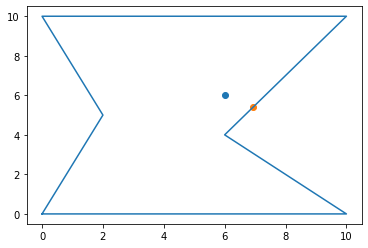

In [6]:
test_pt = Point(6,6)

dis = lr3.project(test_pt)


print(dis)

point = lr3.interpolate(dis)

plt.scatter(test_pt.x, test_pt.y)
plt.scatter(point.x, point.y)
plot_ring(lr3)

5.9422508216656595
1.2998673672393628
1.4142135623730951


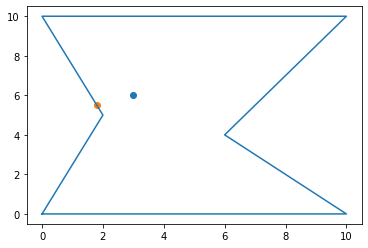

In [7]:
test_pt = Point(3,6)

dis = lr3.project(test_pt)


print(dis)

point = lr3.interpolate(dis)

plt.scatter(test_pt.x, test_pt.y)
plt.scatter(point.x, point.y)
plot_ring(lr3)


print(point.distance(test_pt))

print(test_pt.distance(Point(2,5)))

2.0
1.0


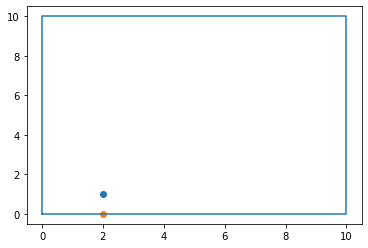

In [8]:
test_pt = Point(2,1)

rr1 = reverse(lr1)

dis = rr1.project(test_pt)


print(dis)

point = rr1.interpolate(dis)

plt.scatter(test_pt.x, test_pt.y)
plt.scatter(point.x, point.y)
plot_ring(rr1)

print(point_dis(test_pt, point))

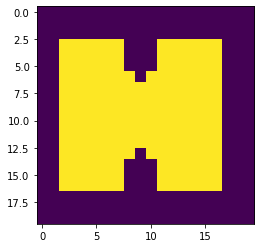

In [9]:
image = cv2.imread('area_test.png',0)
plt.imshow(image)

image = image[::1,:]


filename = "Area_test.gcode"

line_dis = 5 # mm

In [10]:
# return a list of lists of lines
def generate_border_lines(image):

    contours,heirarchy = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)  

    contour_list = []

    for contour,heirarchy in zip(contours, heirarchy[0]):
        point_list = []
        pt0 = None
        for point in contour:
            point_list.append(tuple(point[0]))
            
        contour_list.append((point_list, heirarchy))

    return contour_list

In [11]:
# get all of the children of the parent contour
def get_children(contour_list, parent_contour):

    child_list = []

    first_child_index = parent_contour[1][2]
    child = contour_list[first_child_index]
    child_list.append(child[0])


    # loop while there are more children
    while not child[1][0] == -1:
        next_child_index = child[1][0]
        child = contour_list[next_child_index]
        child_list.append(child[0])
    
    # return the list of children
    return child_list

In [12]:
# combine contours into single level parent-children relationships
def create_contour_families(contour_list):

    family_list = []

    # find the first parent contour
    for contour in contour_list:
        
        # start with a parent contour
        if contour[1][3]==-1:

            # if there are no children, create an empty family with only the parent contour
            if contour[1][2] == -1:
                child_list = []
            # otherwise, find all of the children
            else:
                child_list = get_children(contour_list, contour)

            if len(contour[0]) > 2:
                family_list.append(Polygon(contour[0], holes=child_list))

    return family_list

In [13]:
def distance_transform(polygon, distance):
        
    t = polygon.buffer(distance)
    
    # if t is empty, return the empty list
    if not t:
        return []
        
    result = []

    if t.type == "MultiPolygon":
        for p in t:
            result.append([p])
            result[-1].extend(distance_transform(p, distance))
    else:
        result.append(t)
        result.extend(distance_transform(t, distance))
        
        
    return result

In [18]:

polygon = generate_border_lines(image)
print(polygon[0])

result = distance_transform(polygon[0],0.3)




([(2, 3), (2, 16), (7, 16), (7, 14), (9, 12), (11, 14), (11, 16), (16, 16), (16, 3), (11, 3), (11, 5), (9, 7), (7, 5), (7, 3)], array([-1, -1, -1, -1], dtype=int32))


AttributeError: 'tuple' object has no attribute 'buffer'